In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import stylia as st
from stylia import NamedColors

colors=NamedColors()

color_dict ={"arv": colors.blue,
             "coad": colors.orange,
             "mtb": colors.green}

datapath = "../data"
outpath = "../output"

In [24]:
datasets = ["arv", "coad", "mtb"]
dfs = []
for d in datasets:
    df = pd.read_csv(os.path.join(outpath, "results", f"{d}_preds.csv"))
    indication = d
    df["indication"] = indication
    dfs += [df]

df = pd.concat(dfs)
df.shape

(123, 10)

In [26]:
df[df["name"]=="Penicillin G"]

,name,smiles,indication,sarathy2016,janardhan2016,radchenko2023,lepori2025_mtb,lepori2025_msm,mycpermcheck,valitalo2016
2,Penicillin G,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,coad,0.365449,0.559854,0.080922,0.486483,0.458377,0.061108,0.266013


In [27]:
entry = ["coad_entry", "arv_entry", "mtb_entry"]
dfs = []
for d in entry:
    df_ = pd.read_csv(os.path.join(outpath, "results", f"{d}.csv"))
    indication = d.split("_")[0]
    df_["indication"] = indication
    dfs += [df_]
df_entry = pd.concat(dfs)
df_entry.rename(columns={"smiles":"name"}, inplace=True)

df = df.merge(df_entry[["name","rb", "glob", "pbf", "primary_amine"]], on=["name"])
df.rename(columns={"rb":"entry_rb", "glob":"entry_glob", "pbf":"entry_pbf", "primary_amine":"entry_amine"}, inplace=True)

In [28]:
import numpy as np

df["entry_amine"]=df.entry_amine.replace({True:1, False:0})
entry = {
    "entry_rb": (4, "l"),
    "entry_glob": (0.2, "l"),
    "entry_pbf": (1, "l"),
    "entry_amine": (0.5, "h")
}

bools = np.zeros(shape=(len(entry),len(df)))

a=0
for k,v in entry.items():
    for c in df.columns.tolist():
        if k==c:
            v, d = v
            if d == "l":
                b = np.where(df[c]<=v, True, False)
            else:
                b = np.where(df[c]>=v, True, False)
            bools[a]=b
            a = a+1
df["entry_score"]=bools.sum(axis=0)

/tmp/ipykernel_3052874/2084829542.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["entry_amine"]=df.entry_amine.replace({True:1, False:0})


In [29]:
eos65rt = ["coad_eos65rt", "arv_eos65rt", "mtb_eos65rt"]
dfs = []
for d in eos65rt:
    df_ = pd.read_csv(os.path.join(outpath, "results", f"{d}.csv"))
    indication = d.split("_")[0]
    df_["indication"] = indication
    dfs += [df_]
df_eos65rt = pd.concat(dfs)
df_eos65rt.rename(columns={"input":"smiles"}, inplace=True)

df = df.merge(df_eos65rt[["smiles","clogp"]], on=["smiles"])

In [30]:
df

,name,smiles,indication,sarathy2016,janardhan2016,radchenko2023,lepori2025_mtb,lepori2025_msm,mycpermcheck,valitalo2016,entry_rb,entry_glob,entry_pbf,entry_amine,entry_score,clogp
0,abacavir,C1CC1NC2=C3C(=NC(=N2)N)N(C=N3)C4CC(C=C4)CO,arv,0.453601,0.173188,0.126154,0.966679,0.966561,0.277874,0.594216,4,0.081513,0.790970,0,3.0,0.702811
1,amprenavir,CC(C)CN(CC(C(CC1=CC=CC=C1)NC(=O)OC2CCOC2)O)S(=...,arv,0.217787,0.541462,0.240935,0.707099,0.797679,0.075336,0.513373,12,0.175923,1.256505,0,1.0,2.334426
2,atazanavir,CC(C)(C)C(C(=O)NC(CC1=CC=CC=C1)C(CN(CC2=CC=C(C...,arv,0.069929,0.790274,0.453341,0.710765,0.737063,0.172184,0.645384,18,0.088717,1.188236,0,1.0,4.408189
3,cabotegravir,C[C@H]1CO[C@H]2N1C(=O)C3=C(C(=O)C(=CN3C2)C(=O)...,arv,0.328605,0.833194,0.332284,0.692831,0.664961,0.122739,0.488927,3,0.052589,0.818442,0,3.0,1.012404
4,darunavir,CC(C)CN(CC(C(CC1=CC=CC=C1)NC(=O)OC2COC3C2CCO3)...,arv,0.163575,0.600120,0.283383,0.769958,0.805114,0.070165,0.505747,12,0.056441,0.997419,0,2.0,2.340717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,Sutezolid,CC(=O)NC[C@H]1CN(C(=O)O1)c2ccc(c(c2)F)N3CCSCC3,mtb,0.518098,0.699818,0.318136,0.867998,0.918943,0.246303,0.515984,4,0.064539,0.866510,0,3.0,2.182979
121,Tedizolid,CN1N=C(N=N1)C2=NC=C(C=C2)C3=C(C=C(C=C3)N4C[C@@...,mtb,0.327870,0.817270,0.382243,0.679752,0.737119,0.084677,0.684902,4,0.018439,0.551132,0,3.0,0.573671
122,Terizidone,C1C(C(=O)NO1)N=CC2=CC=C(C=C2)C=NC3CONC3=O,mtb,0.361541,0.458219,0.208746,0.416399,0.504214,0.400494,0.549335,4,0.034153,0.659252,0,3.0,0.690343
123,Thioacetazone,CC(=O)NC1=CC=C(C=C1)C=NNC(=S)N,mtb,0.673526,0.336434,0.387374,0.799553,0.927952,0.790852,0.508163,4,0.045710,0.561176,0,3.0,1.137556


In [31]:
df.to_csv(os.path.join(outpath, "results", "allpreds.csv"), index=False)

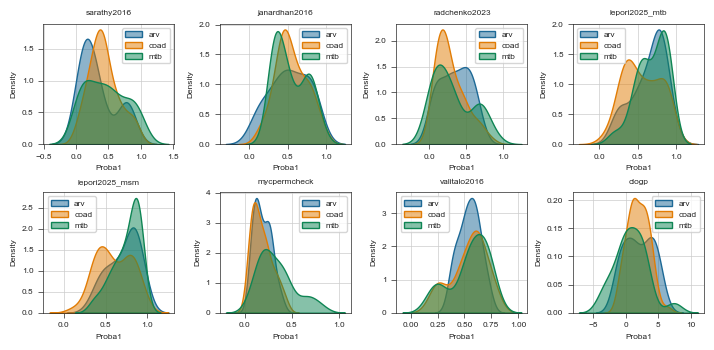

In [32]:
models = ["sarathy2016", "janardhan2016", "radchenko2023", "lepori2025_mtb", "lepori2025_msm", "mycpermcheck", "valitalo2016", "clogp"]

fig, axs=st.create_figure(2,4, width=st.TWO_COLUMNS_WIDTH)
for m in models:
    ax = axs.next()
    for d in datasets:
        df_ = df[df["indication"]==d]
        sns.kdeplot(ax=ax, x = df_[m].tolist(), color=color_dict[d], label=d, alpha=0.5, fill=True)
    ax.set_title(f"{m}")  
    ax.set_xlabel("Proba1")
    ax.set_ylabel("Density")
    ax.legend()
plt.tight_layout()
st.save_figure(os.path.join(outpath, "plots", "prediction_distribution.png"))

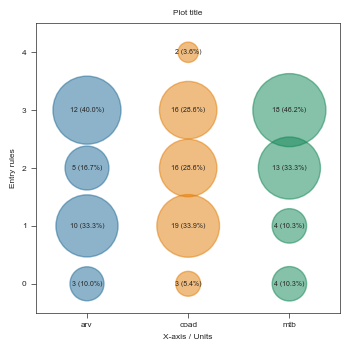

In [33]:
import collections
import stylia as st
import matplotlib.pyplot as plt
from stylia import NamedColors

colors=NamedColors()

color_dict ={"arv": colors.blue,
             "coad": colors.orange,
             "mtb": colors.green}

entry_counts = collections.defaultdict(int)

for r in df[["indication", "entry_score"]].values:
    entry_counts[(r[0], r[1])] += 1

fig, axs = st.create_figure(1,1)
ax = axs.next()
for i, ind in enumerate(["arv", "coad", "mtb"]):
    x = []
    y = []
    z = []
    for k,v in entry_counts.items():
        if k[0] != ind: continue
        x += [i]
        y += [k[1]]
        z += [v]
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    z_ = z/np.sum(z)
    ax.scatter(x, y, s=z_*6000, alpha=0.5,color=color_dict[ind])
    for j in range(len(x)):
        ax.text(x[j], y[j], "{0} ({1}%)".format(z[j], round(z_[j]*100,1)), va="center", ha="center")
ax.set_yticks([j for j in range(5)])
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["arv", "coad", "mtb"])
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 4.5)
ax.grid()
ax.set_ylabel("Entry rules")

plt.tight_layout()

st.save_figure(os.path.join(outpath,"plots", "entry_rules.png"))

In [34]:
def stripplot_graph(df, model, ax):
    palette = {
        "arv": colors.blue,
        "coad": colors.orange,
        "mtb": colors.green
    }
    sns.stripplot(x="indication", y=model, data=df, order=["arv", "coad", "mtb"], ax=ax, size=3, palette=palette)
    PROPS = {
        'boxprops':{'facecolor':'none', 'edgecolor':'black'},
        'medianprops':{'color':'black'},
        'whiskerprops':{'color':'black'},
        'capprops':{'color':'black'}
    }
    sns.boxplot(x="indication", y=model, data=df, order=["arv", "coad", "mtb"], ax=ax, color="white", linewidth=1, **PROPS)
    ax.set_title(model)
    ax.set_ylabel("")
    ax.set_xlabel("")

/tmp/ipykernel_3052874/4108155502.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="indication", y=model, data=df, order=["arv", "coad", "mtb"], ax=ax, size=3, palette=palette)
/tmp/ipykernel_3052874/4108155502.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="indication", y=model, data=df, order=["arv", "coad", "mtb"], ax=ax, size=3, palette=palette)
/tmp/ipykernel_3052874/4108155502.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="indication", y=model, data=df, order=["arv", "coad", "mtb"], ax=ax, size=3, palette=pale

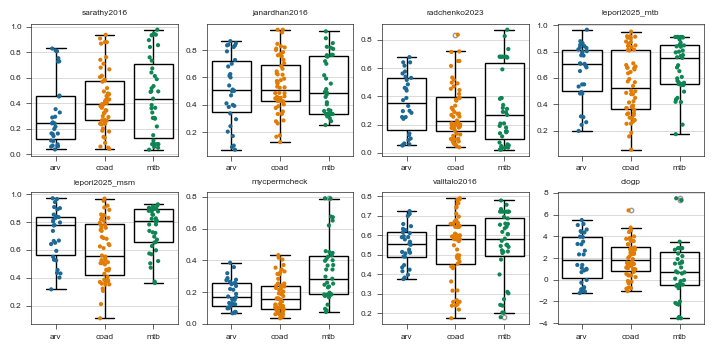

In [35]:
models = ["sarathy2016", "janardhan2016", "radchenko2023", "lepori2025_mtb", "lepori2025_msm", "mycpermcheck", "valitalo2016", "clogp"]
fig, axs = st.create_figure(2,4)
for m in models:
    ax = axs.next()
    stripplot_graph(df, m, ax)
    plt.tight_layout()
st.save_figure(os.path.join(outpath,"plots", "preds_eval.png"))